# Task 1: Homogeneity or heterogeneity?
Analyzing song features both in terms of lyrics and audio in Billboard Hot 100 from 1950 to 2015

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn import preprocessing
import utils        # stores the helper function

In [2]:
# data source: 
# https://github.com/kevinschaich/billboard
# https://towardsdatascience.com/billboard-hot-100-analytics-using-data-to-understand-the-shift-in-popular-music-in-the-last-60-ac3919d39b49
music_df = pd.read_csv('data/music_df.csv')

In [3]:
# source: https://towardsdatascience.com/how-to-show-all-columns-rows-of-a-pandas-dataframe-c49d4507fcf
# display.max_columns option controls the number of columns to be printed
pd.set_option('display.max_columns', None)
music_df.head()

,lyrics,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,title,f_k_grade,artist,difficult_words,num_dupes,neg,neu,compound,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,uri,analysis_url,artist_with_features,year_bin,image,cluster,Gender
0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",189.0,0.199,1950,5.2,88.74,145,17,Mona Lisa,2.9,Nat King Cole,13,10,0.155,0.646,0.8443,3k5ycyXX5qsCjLd7R2vphp,0.214,0.194,1,-15.636,1,0.0325,0.903,0.000001,0.107,0.339,86.198,207573.0,3,spotify:track:3k5ycyXX5qsCjLd7R2vphp,https://api.spotify.com/v1/audio-analysis/3k5y...,NaN,50s,https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...,String Lover,male
1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,270.9,0.224,1950,4.4,82.31,189,31,I Wanna Be Loved,3.3,Andrews Sisters,40,32,0.036,0.740,0.9897,4UY81WrDU3jTROGaKuz4uZ,0.358,0.085,8,-13.664,1,0.0389,0.939,0.000000,0.160,0.181,170.869,198027.0,5,spotify:track:4UY81WrDU3jTROGaKuz4uZ,https://api.spotify.com/v1/audio-analysis/4UY8...,Gordon Jenkins,50s,https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...,String Lover,Group
2,I was dancing with my darling to the Tennessee...,174.6,0.351,1950,5.2,88.74,138,16,Tennessee Waltz,2.9,Patti Page,5,10,0.053,0.596,0.9948,6DKt9vMnMN0HmlnK3EAHRQ,0.424,0.163,3,-15.899,1,0.0276,0.784,0.000671,0.116,0.294,86.335,182733.0,3,spotify:track:6DKt9vMnMN0HmlnK3EAHRQ,https://api.spotify.com/v1/audio-analysis/6DKt...,NaN,50s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female
3,Each time I hold someone new\nMy arms grow col...,135.9,0.231,1950,4.4,99.23,117,18,I'll Never Be Free,0.9,Tennessee Ernie Ford,10,3,0.167,0.602,0.8842,0KnD456yC5JuweN932Ems3,0.697,0.182,7,-12.586,1,0.0357,0.780,0.000000,0.126,0.474,82.184,158000.0,3,spotify:track:0KnD456yC5JuweN932Ems3,https://api.spotify.com/v1/audio-analysis/0KnD...,Kay Starr,50s,https://i.scdn.co/image/4bd427bb9181914d0fa448...,String Lover,male
4,"Unfortunately, we are not licensed to display ...",46.8,0.079,1950,6.0,69.79,32,3,All My Love,6.0,Patti Page,9,0,0.070,0.850,0.0772,05sXHTLqIpwywbpui1JT4o,0.631,0.273,8,-11.538,1,0.0408,0.801,0.000000,0.158,0.633,123.314,190933.0,4,spotify:track:05sXHTLqIpwywbpui1JT4o,https://api.spotify.com/v1/audio-analysis/05sX...,NaN,50s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female


In [4]:
music_df.columns

Index(['lyrics', 'num_syllables', 'pos', 'year', 'fog_index', 'flesch_index',
       'num_words', 'num_lines', 'title', 'f_k_grade', 'artist',
       'difficult_words', 'num_dupes', 'neg', 'neu', 'compound', 'id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'uri', 'analysis_url',
       'artist_with_features', 'year_bin', 'image', 'cluster', 'Gender'],
      dtype='object')

clean up the `year_bin` category to prepare for decade-by-decade analyses
(ref: week 6—music class notes)

In [5]:
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20'+x if (x == '10s') or (x == '00s') else '19'+x)

## Analyzing the audio features provided by Spotify API 
(ref: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)

In [6]:
# bring "loudness" in the range of [0,1], change in place
preprocessing.minmax_scale(music_df["loudness"], feature_range=(0, 1), axis=0, copy=False)

array([0.38651077, 0.46388355, 0.37619178, ..., 0.76945109, 0.69604112,
       0.82842233])

  year_bin  danceability  energy  loudness  speechiness  valence
0    1950s         0.214   0.194  0.386511       0.0325    0.339
1    1950s         0.358   0.085  0.463884       0.0389    0.181
2    1950s         0.424   0.163  0.376192       0.0276    0.294
3    1950s         0.697   0.182  0.506180       0.0357    0.474
4    1950s         0.631   0.273  0.547299       0.0408    0.633
   year  danceability  energy  loudness  speechiness  valence
0  1950         0.214   0.194  0.386511       0.0325    0.339
1  1950         0.358   0.085  0.463884       0.0389    0.181
2  1950         0.424   0.163  0.376192       0.0276    0.294
3  1950         0.697   0.182  0.506180       0.0357    0.474
4  1950         0.631   0.273  0.547299       0.0408    0.633


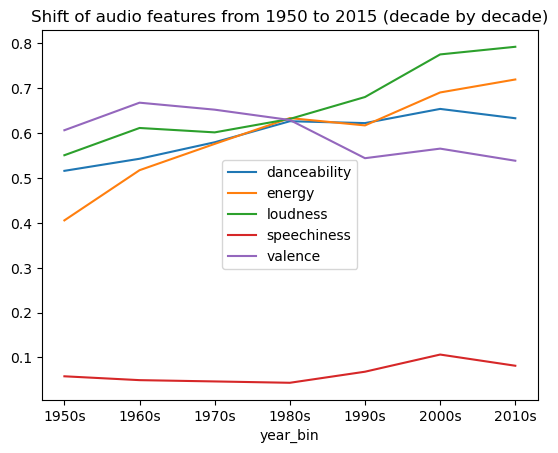

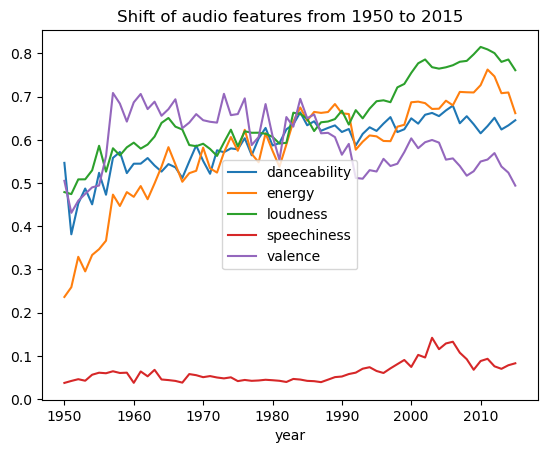

In [7]:
# year: int, the exact year of billboards the music belongs to
# year_bin: str, the decade of billboards the music belongs to

df_yearbin = music_df.loc[:, ["year_bin", "danceability", "energy", 
                              "loudness", "speechiness", "valence"]]
df_year = music_df.loc[:, ["year", "danceability", "energy", 
                           "loudness", "speechiness", "valence"]]
print(df_yearbin.head())
print(df_year.head())

# see the rough tendency first throught the graphs
df_yearbin.groupby('year_bin').mean()\
          .plot(title='Shift of audio features from 1950 to 2015 (decade by decade)');
df_year.groupby('year').mean()\
       .plot(title='Shift of audio features from 1950 to 2015');

Analyzing the shift of danceability: we could observe a statistically significant positive shift over years; in other words, music of Billboard Hot 100 has become more danceable from 1950 to 2015

                            OLS Regression Results                            
Dep. Variable:           danceability   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     235.0
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.32e-51
Time:                        15:16:30   Log-Likelihood:                 1674.7
No. Observations:                4028   AIC:                            -3345.
Df Residuals:                    4026   BIC:                            -3333.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8936      0.294    -13.262      0.0

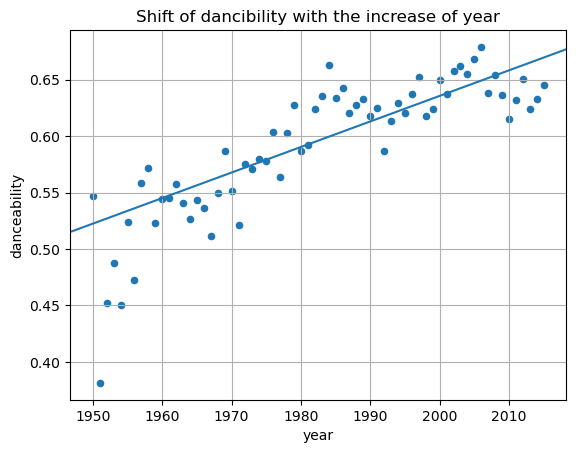

In [12]:
mod = ols(formula='danceability ~ year', data = df_year).fit()
print(mod.summary())    # positive correlation

ax = df_year.groupby('year', as_index=False)\
            .mean()\
            .plot(x='year', y='danceability', kind='scatter',
                  title='Shift of dancibility with the increase of year', grid=True);

# plot regression line
fig = sm.graphics.abline_plot(model_results=mod, ax=ax)

From the OLS regression above, the danceablity of the Billboard songs has a significant positive relationship with the progession of time. Similarly, we could see a statistically significant difference of other audio features—energy, loudness, speechiness, and valence over the years.

I wrote the above codes into a helper function(ols_summary_plot) in utils.py for repetitive uses.

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     614.3
Date:                Wed, 23 Nov 2022   Prob (F-statistic):          2.48e-126
Time:                        15:16:21   Log-Likelihood:                 862.32
No. Observations:                4028   AIC:                            -1721.
Df Residuals:                    4026   BIC:                            -1708.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.2877      0.359    -23.073      0.0

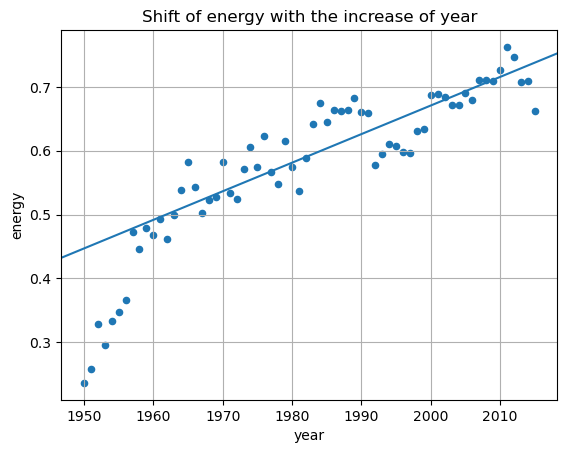

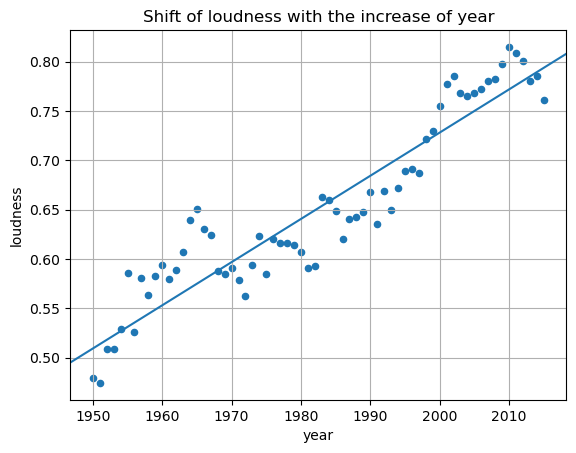

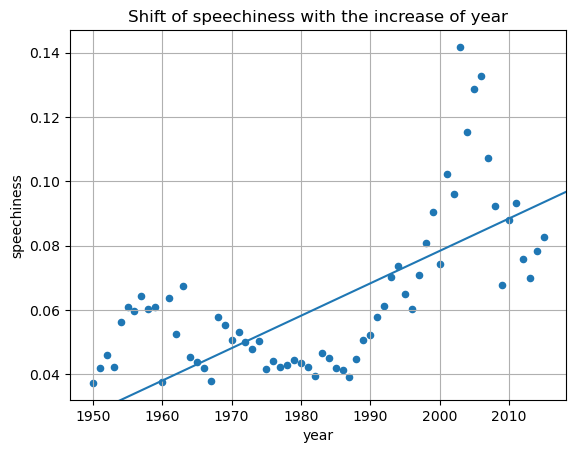

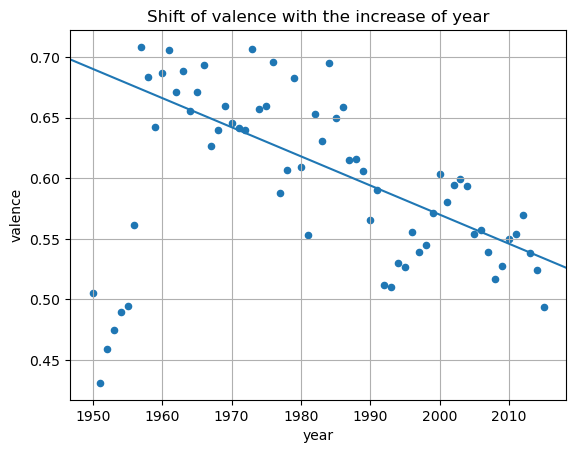

In [9]:
utils.ols_summary_plot('energy', 'year', df_year)       # positive correlation
utils.ols_summary_plot('loudness', 'year', df_year)     # positive correlation
utils.ols_summary_plot('speechiness', 'year', df_year)  # positive correlation
utils.ols_summary_plot('valence', 'year', df_year)      # negative correlation

## Analyzing the lyrics features
(ref: https://github.com/kevinschaich/billboard)

For lyrics, we look at sentiment (compound score), readibility (Flesch–Kincaid grade level, Flesch reading ease score, Gunning-Fog readability index, number of words not on the Dale–Chall "easy" word list) and repetitiveness (number of duplicate (repetitive) lines in lyrics).

Similar codes are used to examine whether a statistically significant shift over years exists.

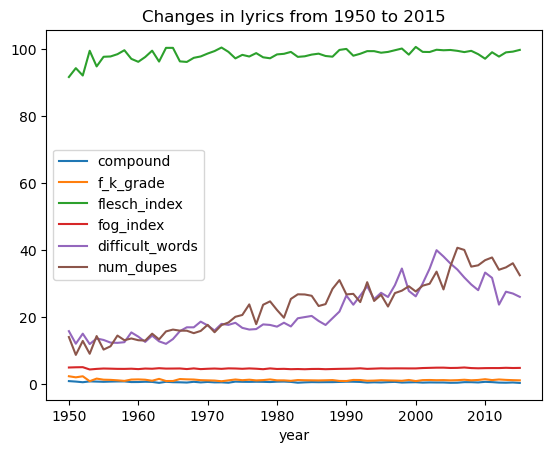

In [10]:
lyrics_year_df = music_df.loc[:, ["year", "compound", "f_k_grade", "flesch_index", "fog_index", "difficult_words", "num_dupes"]]
lyrics_year_df.groupby("year").mean()\
          .plot(title='Changes in lyrics from 1950 to 2015');

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     21.24
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           4.18e-06
Time:                        15:16:22   Log-Likelihood:                -4574.0
No. Observations:                4028   AIC:                             9152.
Df Residuals:                    4026   BIC:                             9165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9026      1.385      4.984      0.0

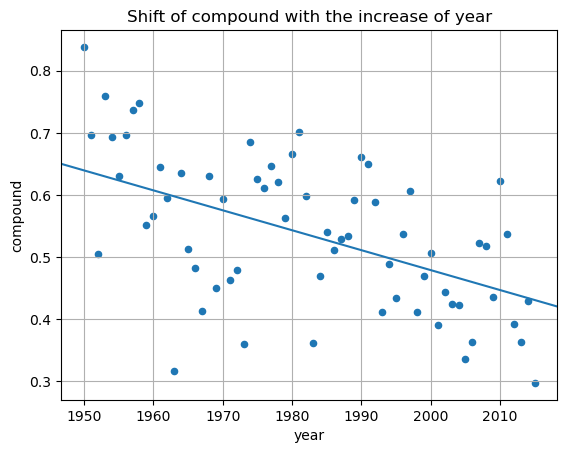

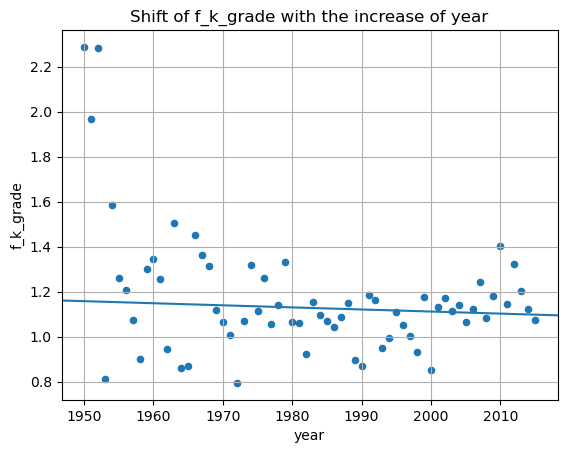

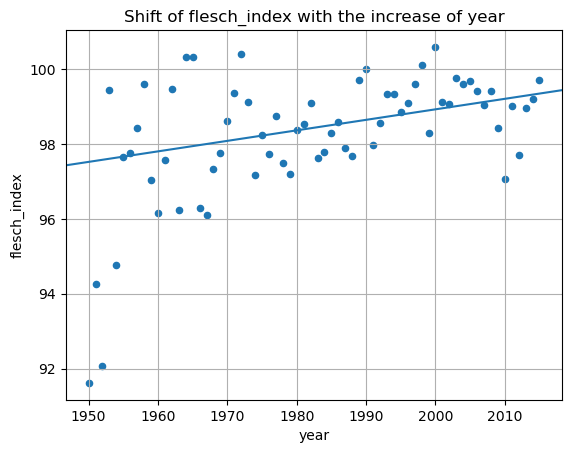

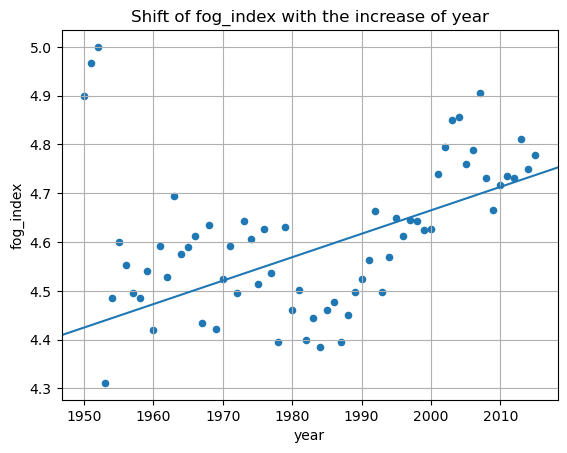

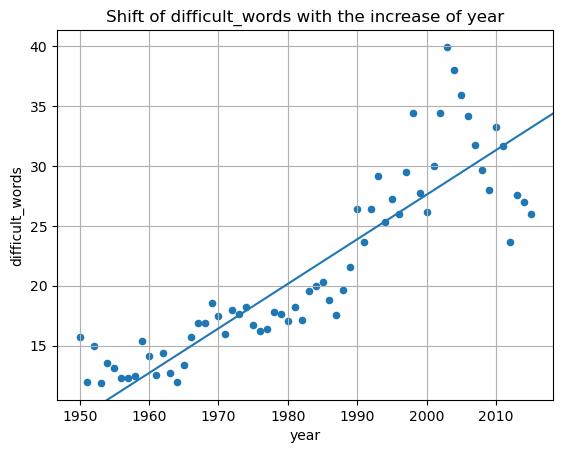

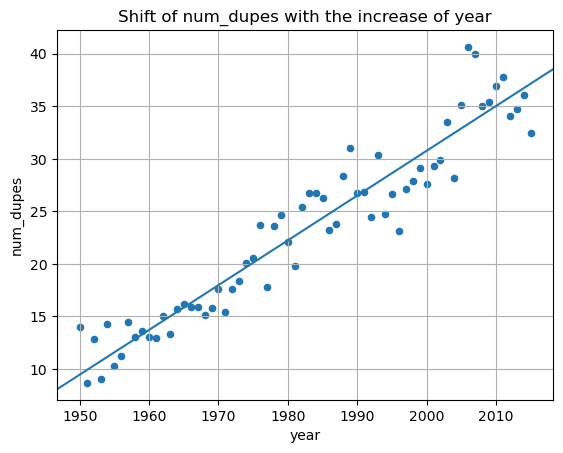

In [11]:
utils.ols_summary_plot("compound", "year",lyrics_year_df)      # negative correlation
utils.ols_summary_plot("f_k_grade", "year", lyrics_year_df)     # no significant relations
utils.ols_summary_plot("flesch_index", "year", lyrics_year_df)  # postive correlation
utils.ols_summary_plot("fog_index", "year", lyrics_year_df)     # postive correlation
utils.ols_summary_plot("difficult_words", "year", lyrics_year_df) # postive correlation
utils.ols_summary_plot("num_dupes", "year", lyrics_year_df)     #postive correlation

To identify the *homogenization or heterogenization* of Billboard Hot 100 songs over the years (i.e., from 1950 to 2015), I divided the song features into audio and lyric features and separately investigated the changes, or lack thereof, using linear regression analysis.

For audio features, I focused on danceability, energy (intensity and activity), loudness (in dB), speechiness (presence of spoken words), and valence (musical positiveness). Regarding all these features, we could observe a statistically significant difference over the years. Popular songs appeared **more danceable, energetic, loud, and speech-like while less happy** as the years passed. 

I then applied the same method to investigate the lyrics' sentiment, readability, and repetitiveness. As a result, **the sentiment of the lyrics is significantly more negative, and the lines are more repetitive** over the years. When it comes to readability, the metrics present conflicting results. The lyrics became harder to read over the years according to the count of complex words (based on the Dale–Chall "easy" word list) and Gunning-Fog readability index, as the results show that there are significantly more difficult words in lyrics and reading them require people of higher educational level. However, opposite results appear in the Flesch reading ease score analysis, and no significant difference was found in Flesch–Kincaid grade level. Therefore, the dataset might not be sufficient to support the shift in the readability of lyrics over time.

This analysis by no means exhausts the various features of songs. Nevertheless, we could identify interesting and statistically significant changes in multiple features—audio and texts. I conclude that popular music is **not homogeneous** with time, at least not from the 1950s to the 2010s.

____

# Task 2: Developing a Theory of the Identified Heterogenization

Frith (1996, p. 158) points out that there are generally two strategies for examining songs—considering them as pure “literary objects” (i.e., texts) and as “speech acts.” 

From the previous analysis, I identified patterns of heterogenization of Billboard Hot 100 songs from a longitudinal perspective—both in terms of literary objects and speech acts, consistent with two streams of past song research using Billboard charts. Focusing on the lyrics, past content analyses have revealed significant changes over the years. For example, Christenson et al. (2012) found substantially more mentions of substance use from 1968 to 2008 in a decade-by-decade analysis of 496 songs from Billboard Year-End Hot 100. On the other hand, researchers have investigated songs as speech acts (e.g., tempo, Roessner, 2017) and also found heterogenization over the years.

What are the possible reasons for the heterogenization of popular songs from the last century till this decade? To answer this question, we could follow the framework of the Circuit of Culture and think about the five components—representation, identity, production, consumption, and regulation (Du Gay et al., 2013). My analysis and other relevant research have revealed the heterogenization of the representation of an important cultural artifact—songs. The other four components could interrelatedly contribute to this shift over time. In each aspect, the change of behaviors and beliefs possibly involves complex contagion models (Guilbeault et al., 2018, p. 4), suggesting that multiple sources of activation are needed to change each component. 

First, from the perspective of Identify, the heterogenization of commonly held values may have led to heterogeneous representations. Frith (1996, p. 169) claims that “the song is an argument;” singers argue with songs. The arguments are made through the song text itself and how the message is conveyed. Understandably, The arguments people want to make today are drastically different from those in the 1950s. Therefore, the lyrics, as well as the sound of songs, have changed.

Second, on the Consumption side, the technological shift has played a huge role in changes in popular songs over the years. How people consume songs has experienced a huge shift from a time with no widespread Internet coverage to the digital age when we carry digital devices with us all the time. Therefore, we ought to consider the possible connection between the advance of technology, conventional consumption ways, and the heterogenization of popular songs over the decades. 

From the Production’s standpoint, there might be less imitation of the song creators than people might conjecture. Suppose we are to speculate the music homogenization over time. In that case, a significant contributor people would point out is creators’ copying the elements of the most popular songs at the time, or as Frith (1996, p. 167) put it, “cultural domination leads to imitation.” He went on to give the example of British singers adopting more American-like accents when American musicians dominated the global music industry, but eventually, there were fewer and fewer accent imitations from British singers. So why has the imitation not lasted? The answer might be found in other components of the Circuit of Culture (Du Gay et al., 2013); consumers could get tired of repetitive elements of music, or less strict rules are in power today than decades ago. Anyways, there is little doubt that changes in production lead to the heterogenization of the representation.

Last, regarding Regulation, I propose to extend it to less formal rules—not only official laws and market regulations but also the rules of “popularity.” The latter could substantially impact the representation of songs. If expectations of a few significant judges determine which songs or singers arrive on the Billboard chart, there will be expectedly more homogeneity of those Billboard songs or singers. However, in the age of information sharing, word-of-mouth may weigh more and more and even surpass the power of certain “authorities” like music critics. This shift in the “rules of popularity” might contribute to the changes in lyrics and performance of lyric texts of popular songs. 

Taken together, no single element but the shift of the entire Circuit of Culture possibly accounts for the heterogenization of Billboard Hot 100 songs. To explain the changes in Representation, shifts in Identity, Consumption, Production, and Regulation all deserve consideration.